In [14]:
# Import python libraries
import Haver as hv
import wbdata as wb
import pandas as pd
import numpy as np
import datetime as dt
import docx
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from matplotlib import pyplot as plt
import seaborn as sns

# Set the country for the report
country = 'RUS'

# Create a blank Word document where the output will be exported
doc = docx.Document()
# Add a heading for the title
doc.add_heading(f'{country}: Asian Development Outlook', level=0)

In [15]:
# Create a table of historical GDP and components (expenditure) table

# Create a dictionary of GDP indicators
gdp = {'NY.GDP.MKTP.KD.ZG': 'GDP growth (%)',
       'NE.CON.PRVT.ZS': 'Private consumption (% of GDP)', 
       'NE.CON.GOVT.ZS': 'Government expenditures (% of GDP)',
       'NE.GDI.TOTL.ZS': 'Gross capital formation (% of GDP)', 
       'NE.EXP.GNFS.ZS': 'Exports (% of GDP)',
       'NE.IMP.GNFS.ZS': 'Imports (% of GDP)',
       'NE.CON.PRVT.KD.ZG': 'Private consumption (annual growth, %)', 
       'NE.CON.GOVT.KD.ZG': 'Government expenditure (annual growth, %)',
       'NE.GDI.TOTL.KD.ZG': 'Gross capital formation (annual growth, %)',
       'NE.EXP.GNFS.KD.ZG': 'Exports (annual growth, %)',
       'NE.IMP.GNFS.KD.ZG': 'Imports (annual growth, %)'}

# Set the time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape the data from WB API
df_gdp = wb.get_dataframe(indicators=gdp, country=country, data_date=data_date, source=2)

# Sort dataframe according to year
df_gdp = df_gdp.reset_index().sort_values(by='date').reset_index(drop=True)

# Generate share of net exports in GDP
net_exports_share = df_gdp['Exports (% of GDP)'] - df_gdp['Imports (% of GDP)']
df_gdp.insert(7, 'Net exports (% of GDP)', net_exports_share)

# Generate series of contribution to GDP growth
df_gdp['Private consumption (contribution, pp)'] = df_gdp.iloc[:, 2].shift(1) / 100 * df_gdp.iloc[:, 8]
df_gdp['Government expenditures (contribution, pp)'] = df_gdp.iloc[:, 3].shift(1) / 100 * df_gdp.iloc[:, 9]
df_gdp['Gross capital formation (contribution, pp)'] = df_gdp.iloc[:, 4].shift(1) / 100 * df_gdp.iloc[:, 10]
df_gdp['Exports (contribution, pp)'] = df_gdp.iloc[:, 5].shift(1) / 100 * df_gdp.iloc[:, 11]
df_gdp['Imports (contribution, pp)'] = df_gdp.iloc[:, 6].shift(1) / 100 * df_gdp.iloc[:, 12]
df_gdp['Net exports (contributio, pp)'] = df_gdp['Exports (contribution, pp)'] - \
df_gdp['Imports (contribution, pp)']

# Round values to one decimal place
df_gdp = df_gdp.round(1)

# Create a dataframe for the top three biggest sources of growth
top_share = pd.DataFrame(df_gdp.iloc[-1, [2, 3, 4, 7]].sort_values(ascending=False))
top_share.columns = ['share']
new_index = [i[:-11] for i in top_share.index]
top_share.index = new_index

In [16]:
# Write the section on GDP growth in the latest year

# Set placeholders
latest_year = df_gdp['date'].iloc[-1]
old_year = df_gdp['date'].iloc[-2]
latest_gdp_growth = df_gdp.iat[-1, 1]
old_gdp_growth = df_gdp.iat[-2, 1]
increased, decreased = latest_gdp_growth > old_gdp_growth, latest_gdp_growth < old_gdp_growth
f_string = 'increased' if increased else 'decreased' 

# Add a heading for GDP growth section
doc.add_heading(f'GDP growth in {latest_year}', level=1)

# Add a paragraph on GDP growth comparison
p = doc.add_paragraph(f'Overall GDP growth: GDP growth {f_string} from {old_gdp_growth}% in {old_year} \
to {latest_gdp_growth}% in {latest_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set placeholders
top_one_share = top_share.iat[0, 0]
top_one_var = top_share.index[0]
top_two_share = top_share.iat[1, 0]
top_two_var = top_share.index[1]
top_three_share = top_share.iat[2, 0]
top_three_var = top_share.index[2]
least_share = top_share.iat[3, 0]
least_share_var = top_share.index[3]
positive, negative = least_share > 0, least_share < 0
f_string = 'positive' if positive else 'negative'
    
# Add a paragraph on the top three components with biggest share
p = doc.add_paragraph(f'Top 3 contributions with {top_one_var} contributing the most ({top_one_share}%), \
followed by {top_two_var} ({top_two_share}%) and {top_three_var} ({top_three_share}%).', 
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Add a paragraph on the component with the least share
p = doc.add_paragraph(f'Contributions in the opposite direction of overall growth: On the other hand, \
{least_share_var} had a {f_string} contribution at {least_share}% of GDP.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY



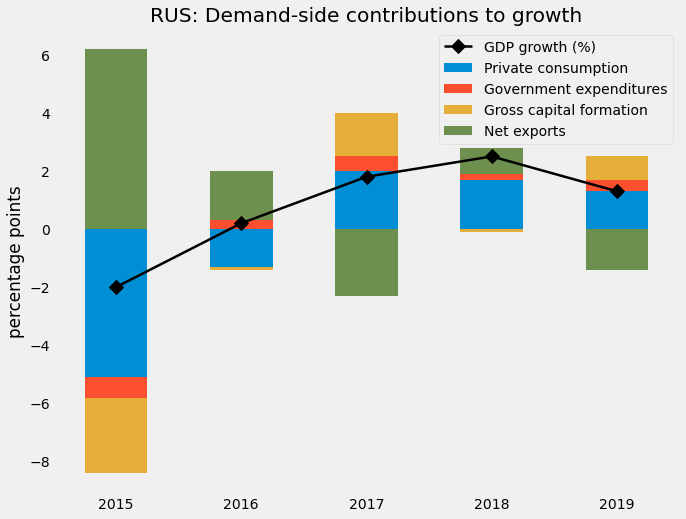

In [17]:
# Create the dataframe that will be plotted
df_graph = df_gdp.iloc[:, [0, 1, 13, 14, 15, 18]].dropna()

# Create a blank canvas
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')

# Create a stacked bar chart of the components
df_graph.set_index('date').iloc[:, 1:].plot(kind='bar', stacked=True, ax=ax)

# Create a line plot of the GDP growth series
ax.plot(df_graph['date'], df_graph.iloc[:, 1], lw=2.5, marker='D', markersize=10, color='black',
        label='GDP growth')

# Set legend
ax.legend(['GDP growth (%)', 'Private consumption', 'Government expenditures', 
           'Gross capital formation', 'Net exports'])

# Set graph formatting and save to local folder
ax.set_title(f'{country}: Demand-side contributions to growth')
ax.set_ylabel('percentage points')
ax.set_xlabel('')
plt.xticks(rotation=0)
ax.grid(False)
plt.savefig(f'{country}_GDP_components.png')

# Add picture to the document
graph = doc.add_picture(f'{country}_GDP_components.png', width=Inches(3.5), height=Inches(3))
last_paragraph = doc.paragraphs[-1]
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

In [18]:
# Write the section on expenditure approach

# Add a heading for Expenditure approach section
doc.add_heading(f'Expenditure approach', level=1)

# Set placeholders
private_consumption_growth_latest = df_gdp.iat[-1, 8]
private_consumption_growth_old = df_gdp.iat[-2, 8]
private_consumption_contribution = df_gdp.iat[-1, 13]
accelerated, contracted = private_consumption_growth_latest > private_consumption_growth_old, \
private_consumption_growth_latest < private_consumption_growth_old
f_string = 'accelerated' if accelerated else 'contracted'

# Add a paragraph on private consumption growth
p = doc.add_paragraph(f'Private consumption: Private consumption growth {f_string} to \
{private_consumption_growth_latest}% ({private_consumption_growth_old}% in {old_year}), \
contributing {private_consumption_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set placeholders
govt_expenditure_growth_latest = df_gdp.iat[-1, 9]
govt_expenditure_growth_old = df_gdp.iat[-2, 9]
govt_expenditure_contribution = df_gdp.iat[-1, 14]
accelerated, contracted = govt_expenditure_growth_latest > govt_expenditure_growth_old, \
govt_expenditure_growth_latest < govt_expenditure_growth_old
f_string = 'accelerated' if accelerated else 'contracted'

# Add a paragraph on government expenditure growth
p = doc.add_paragraph(f'Government expenditures: Government expenditures growth {f_string} to \
{govt_expenditure_growth_latest}% ({govt_expenditure_growth_old}% in {old_year}), \
contributing {govt_expenditure_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set placeholders
gross_cap_formation_growth_latest = df_gdp.iat[-1, 10]
gross_cap_formation_growth_old = df_gdp.iat[-2, 10]
gross_cap_formation_contribution = df_gdp.iat[-1, 15]
accelerated, contracted = gross_cap_formation_growth_latest > gross_cap_formation_growth_old, \
gross_cap_formation_growth_latest < gross_cap_formation_growth_old
f_string = 'increased' if accelerated else 'contracted'

# Add a paragraph on gross capital formation growth
p = doc.add_paragraph(f'Gross capital formation: Growth in gross capital formation {f_string} to \
{gross_cap_formation_growth_latest}% ({gross_cap_formation_growth_old}% in {old_year}), \
contributing {gross_cap_formation_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set placeholders
exports_growth_latest = df_gdp.iat[-1, 11]
exports_growth_old = df_gdp.iat[-2, 11]
exports_contribution = df_gdp.iat[-1, 16]
accelerated, contracted = exports_growth_latest > exports_growth_old, \
exports_growth_latest < exports_growth_old
f_string = 'increased' if accelerated else 'decreased'

# Add a paragraph on gross capital formation growth
p = doc.add_paragraph(f'Exports: Growth in Exports {f_string} to \
{exports_growth_latest}% ({exports_growth_old}% in {old_year}), \
contributing {exports_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

In [19]:
# Create dictionary of industrial production indicator
industrial_production = {'NV.IND.TOTL.KD.ZG': 'Industry (including construction), \
value added (annual growth, %)'}

# Set the time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape the data from WB API
df_industry = wb.get_dataframe(indicators=industrial_production, 
                               country=country, data_date=data_date, source=2)

# Sort dataframe according to year
df_industry = df_industry.reset_index().sort_values(by='date').reset_index(drop=True)

# Round values to one decimal place
df_industry = df_industry.round(1)

# Write section on industrial approach

# Add a heading for the industrial approach section
doc.add_heading(f'Industrial approach', level=1)

# Set placeholders
industrial_production_growth_latest = df_industry.iat[-1, 1]
industrial_production_growth_old = df_industry.iat[-2, 1]
expanded, shrank = industrial_production_growth_latest > 0, industrial_production_growth_latest < 0
up, down = industrial_production_growth_latest > industrial_production_growth_old, \
industrial_production_growth_latest < industrial_production_growth_old
f_string_1 = 'expanded' if expanded else 'shrank'
f_string_2 = 'up' if up else 'down'

# Add a paragraph on private consumption growth
p = doc.add_paragraph(f'Industrial production: Industrial production {f_string_1} by \
{industrial_production_growth_latest}%, {f_string_2} from {industrial_production_growth_old}% growth \
in {old_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

In [20]:
# Create dictionary of unemployment rate indicator
unemployment_rate = {'SL.UEM.TOTL.NE.ZS': 'Unemployment rate (%)'}

# Set the time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape the data from WB API
df_unemployment = wb.get_dataframe(indicators=unemployment_rate,
                                   country=country, data_date=data_date, source=2)

# Sort dataframe according to year
df_unemployment = df_unemployment.reset_index().sort_values(by='date').reset_index(drop=True)

# Round values to one decimal place
df_unemployment = df_unemployment.round(1)

# Write section on income approach

# Add a heading for the income approach section
doc.add_heading(f'Income approach', level=1)

# Set placeholders
unemployment_rate_latest = df_unemployment.iat[-1, 1]
unemployment_rate_old = df_unemployment.iat[-2, 1]
improved, worsened = unemployment_rate_latest < unemployment_rate_old, \
unemployment_rate_latest > unemployment_rate_old
f_string = 'improved' if improved else 'worsened'

# Add a paragraph on employment
p = doc.add_paragraph(f'Employment: Unemployment {f_string} from {unemployment_rate_old}% in \
of total labor force in {old_year} to {unemployment_rate_latest}% in {latest_year}.', 
                      style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

In [21]:
# Create dictionary of inflation rate indicator
inflation = {'FP.CPI.TOTL.ZG': 'Inflation rate (%)'}

# Set the time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape the data from WB API
df_inflation = wb.get_dataframe(indicators=inflation, country=country, data_date=data_date, source=2)

# Sort dataframe according to year
df_inflation = df_inflation.reset_index().sort_values(by='date').reset_index(drop=True)

# Round values to one decimal place
df_inflation = df_inflation.round(1)

# Write section on inflation

# Add a heading for the income approach section
doc.add_heading(f'Inflation', level=1)

# Set placeholders
inflation_latest = df_inflation.iat[-1, 1]
inflation_old = df_inflation.iat[-2, 1]
slowed, remained, picked_up = inflation_latest < inflation_old, inflation_latest == inflation_old, \
inflation_latest > inflation_old
f_string = ''
if slowed:
    f_string = 'slowed down'
elif remained:
    f_string = 'remained stable'
else:
    f_string = 'picked up'

# Add a paragraph on employment
p = doc.add_paragraph(f'Inflation & monetary policy: Inflation {f_string} from \
{inflation_old}% in {old_year} to {inflation_latest}% in {latest_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

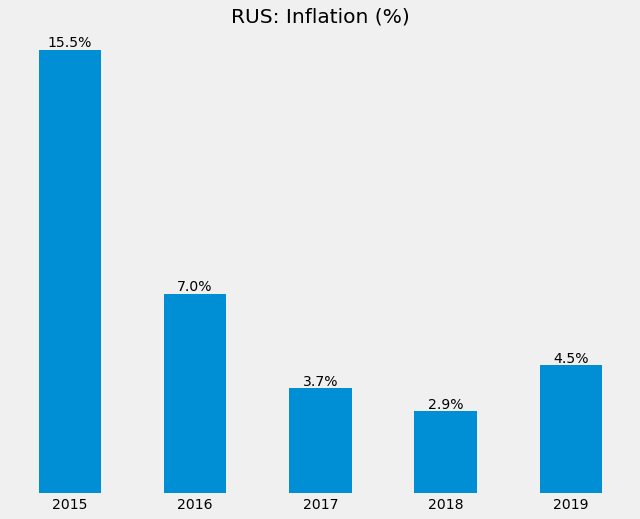

In [22]:
# Create a blank canvas
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')

# Create a dataframe of the inflation chart
df_graph = df_inflation.drop(index=0).reset_index(drop=True).set_index('date')

# Create a bar chart of inflation
df_graph.plot(kind='bar', ax=ax)

# Set legend off
ax.get_legend().remove()

# Set graph formatting
ax.set_title(f'{country}: Inflation (%)')
ax.grid(False)
ax.set_xlabel('')
ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=0)

# Set data labels
labels = df_graph['Inflation rate (%)']

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, str(label) + '%',
            ha='center', va='bottom')

# Save to local folder
plt.savefig(f'{country}_inflation.png')

# Add picture to the document
graph = doc.add_picture(f'{country}_inflation.png', width=Inches(3.5), height=Inches(3))
last_paragraph = doc.paragraphs[-1]
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

In [23]:
# Create dictionary of foreign exchange reserves indicator
reserves = {'FI.RES.TOTL.CD': 'Total reserves (includes gold, current USD)',
            'FI.RES.TOTL.MO': 'Total reserves in months of imports'}

# Set the time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape the data from WB API
df_reserves = wb.get_dataframe(indicators=reserves, country=country, data_date=data_date, source=2)

# Sort dataframe according to year
df_reserves = df_reserves.reset_index().sort_values(by='date').reset_index(drop=True)

# Express reserves in terms of billions

df_reserves.iloc[:, 1] = df_reserves.iloc[:, 1] / 1e9

# Round values to one decimal place
df_reserves = df_reserves.round(1)

# Set placeholders
reserves_latest = df_reserves.iat[-1, 1]
reserves_imports_latest = df_reserves.iat[-1, 2]
strong, weak = reserves_imports_latest >= 12, reserves_imports_latest < 12
f_string = 'strong' if strong else 'weak'

In [24]:
df_reserves

,date,"Total reserves (includes gold, current USD)",Total reserves in months of imports
0,2014,386.2,8.5
1,2015,368.0,12.4
2,2016,377.1,13.2
3,2017,432.7,12.5
4,2018,468.6,12.9
5,2019,555.2,14.5


In [25]:
# Write the section on Outlook

# Add a heading for the Outlook section
doc.add_heading('Outlook', level=1)

# Add a paragraph on Confidence index
p = doc.add_paragraph('Confidence index', style='List Number')

# Add a paragraph on Monetary policy, FX, Inflation
p = doc.add_paragraph(f'FX reserves: Foreign exchange reserves by the central bank  amounted to \
${reserves_latest} in {latest_year}, putting the government in a {f_string} position to defend the \
currency against devaluation pressures.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Add a paragraph on Fiscal policy
p = doc.add_paragraph('Fiscal policy', style='List Number')

# Add a paragraph on Current events
p = doc.add_paragraph('Comments on current events', style='List Number')

# Add a paragraph on leading indicators
p = doc.add_paragraph('Leading indicators', style='List Number')

# Add a paragraph on Consensus Forecasts
p = doc.add_paragraph('Consensus Forecasts', style='List Number')

# Add a paragraph on Risks
p = doc.add_paragraph('Risks', style='List Number')

In [26]:
doc.save(f'{country} ADO Quick Report.docx')